https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

#### Intro
Also known as outlier detection, anomaly detection is a data mining process used to determine types of anomalies found in a data set and to determine details about their occurrences.

Auto anomaly detection has a wide range of applications such as fraud detection, system health monitoring, fault detection, and event detection systems in sensor networks, and so on.

#### Reason
For this post, we will apply anomaly detection to hotel room prices. Have you had experience that, lets say, you travel to a certain destination for business regularly and you always stay at the same hotel. While most of the time, the room rate is almost similar but occasionally for the same hotel, same room type, the rate is unacceptably high, and you’d have to change to another hotel because your travel allowance does not cover that rate. I had been through this several times and this makes me think, what if we could create a model to detect this kind of price anomaly automatically?

#### Goal
In this post, I will explore different anomaly detection techniques and our goal is to search for anomalies in the time series of hotel room prices with unsupervised learning.

### The Data

We are going to slice a subset of the training.csv set:
- Select one single hotel which has the most data point property_id = 104517
- Select visitor_location_country_id = 219 , as we know from the another analysis that country id 219 is the Unites States. The reason we do that is to unify the price_usd column.
- Select search_room_count = 1
- Select the features we need: date_time, price_usd, srch_booking_window, srch_saturday_night_bool.

In [78]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
# subsetting the data

raw = pd.read_csv('/Users/jingli/Desktop/train.csv')

df = raw.loc[raw['prop_id'] == 104517]
df = df.loc[df['srch_room_count'] == 1]
df = df.loc[df['visitor_location_country_id'] == 219]
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [3]:
display(df.info(), df.price_usd.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 2041 to 9917395
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_time                 3049 non-null   object 
 1   price_usd                 3049 non-null   float64
 2   srch_booking_window       3049 non-null   int64  
 3   srch_saturday_night_bool  3049 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


None

count    3049.000000
mean      112.939023
std       113.374049
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max      5584.000000
Name: price_usd, dtype: float64

Note how large the maximum is compared to 75th percentile. This is likely an outlier.

If an individual data instance can be considered as anomalous with respect to the rest of the data, we call it Point Anomalies (e.g. purchase with large transaction value).

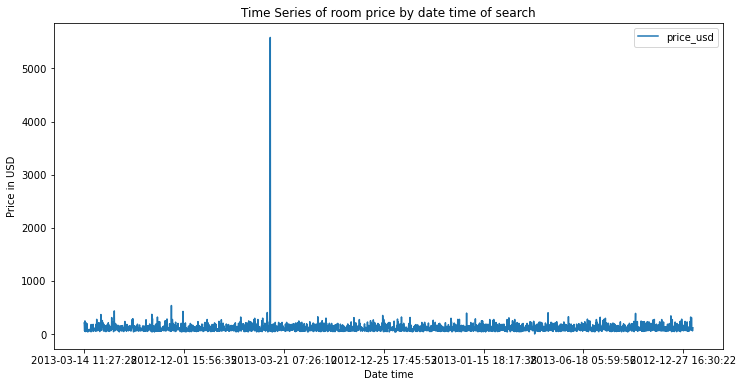

In [4]:
df.plot(x='date_time', y='price_usd', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search');

Note how abnormal the series is, thus we will remove this outlier before continuing.

In [5]:
# remove outlier

df = df.loc[df['price_usd'] < 5584]

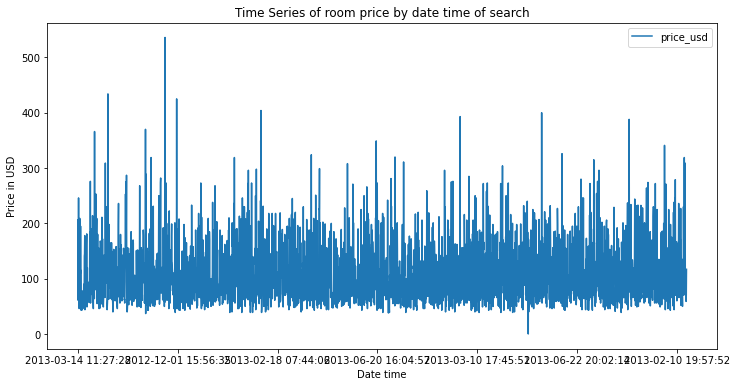

In [6]:
df.plot(x='date_time', y='price_usd', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search');

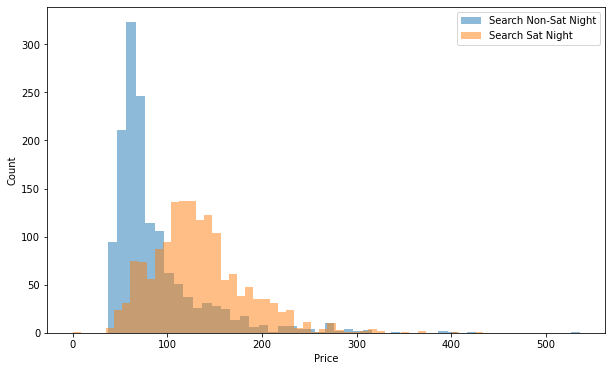

In [7]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search Non-Sat Night')
plt.hist(b, bins = 50, alpha=0.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

In general, the price is more stable and lower when searching Non-Saturday night. And the price goes up when searching Saturday night. Seems this property gets popular during the weekend.

### Clustering Based Anomaly Detection

#### k-means
The algorithm creates ‘k’ similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies. Before we start k-means clustering, we use elbow method to determine the optimal number of clusters.

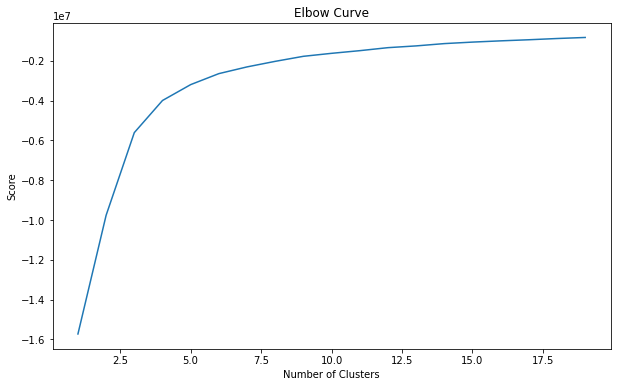

In [8]:
# determine number of cluster first

df_km = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)

kmeans = [KMeans(n_clusters=i).fit(df_km) for i in n_cluster]
scores = [kmeans[i].score(df_km) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From the above elbow curve, we see that the graph levels off after 10 clusters, implying that addition of more clusters do not explain much more of the variance in our relevant variable; in this case price_usd.

We set n_clusters=10, and upon generating the k-means output use the data to plot the 3D clusters.

<ipython-input-28-e8570a907b25>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels.astype(np.float), edgecolor="k")


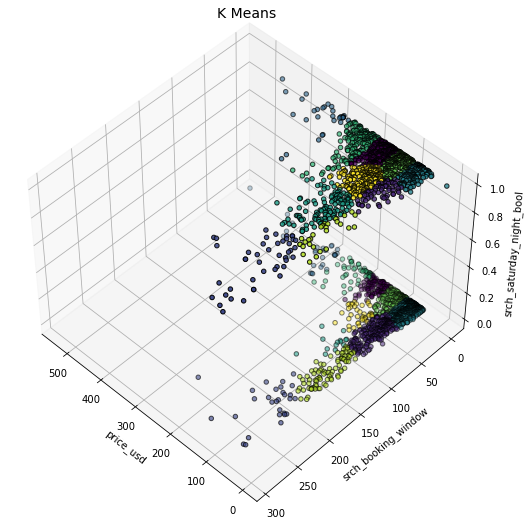

In [28]:
km = KMeans(n_clusters=10)
km.fit(df_km)
km.predict(df_km)
labels = km.labels_

#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(df_km.iloc[:,0], df_km.iloc[:,1], df_km.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

#### PCA
Now we need to find out the number of components (features) to keep.

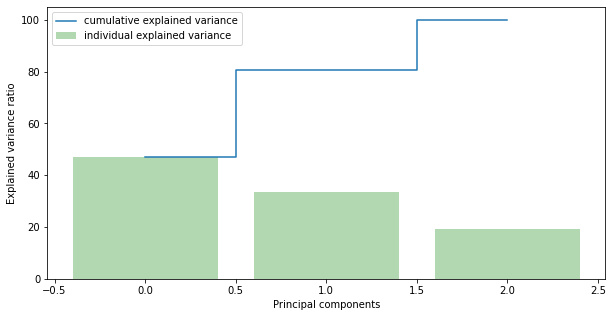

In [10]:
df_pca = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = df_pca.values

# Calculating Eigenvecors and eigenvalues of Covariance matrix
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

We see that the first component explains almost 50% of the variance. The second component explains over 30%. However, we’ve got to notice that almost none of the components are really negligible. The first 2 components contain over 80% of the information. So, we will set n_components=2.

#### PCA + KMeans

In [59]:
# Take useful feature and standardize them
df_2 = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
df_2 = StandardScaler().fit_transform(df_2)

# reduce to 2 important features then apply k-means on pca results
pca = PCA(n_components=2)
df_2 = pca.fit_transform(df_2)
kmeans = [KMeans(n_clusters=i).fit(df_2) for i in n_cluster]

df_2 = pd.DataFrame(df_2)
df.index = df_2.index

df['cluster'] = kmeans[9].predict(df_2)
df['principal_feature1'] = df_2[0]
df['principal_feature2'] = df_2[1]
df['cluster'].value_counts()

8    657
6    576
0    439
2    352
9    348
3    233
5    150
1    148
4     82
7     63
Name: cluster, dtype: int64

The underline assumption in the clustering based anomaly detection is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters.

We use the following steps to find and visualize anomalies:
- Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.
- We use outliers_fraction to provide information to the algorithm about the proportion of the outliers present in our data set. Situations may vary from data set to data set. However, as a starting figure, I estimate outliers_fraction=0.01, since it is the percentage of observations that should fall over 3 absolute value in the Z score distance from the mean in a standardized normal distribution.
- Calculate number_of_outliers using outliers_fraction.
- Set threshold as the minimum distance of these outliers.
- The anomaly result of anomaly1 contains the above method Cluster (0:normal, 1:anomaly).
- Visualize anomalies with cluster view.
- Visualize anomalies with Time Series view.

<ipython-input-60-6b7b89e36e2a>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


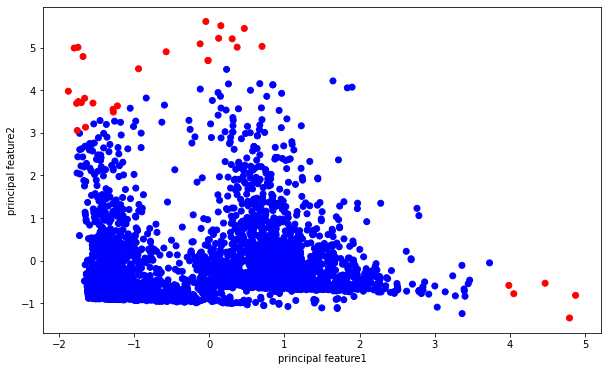

In [60]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(df_2, kmeans[9])

outliers_fraction = 0.01
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

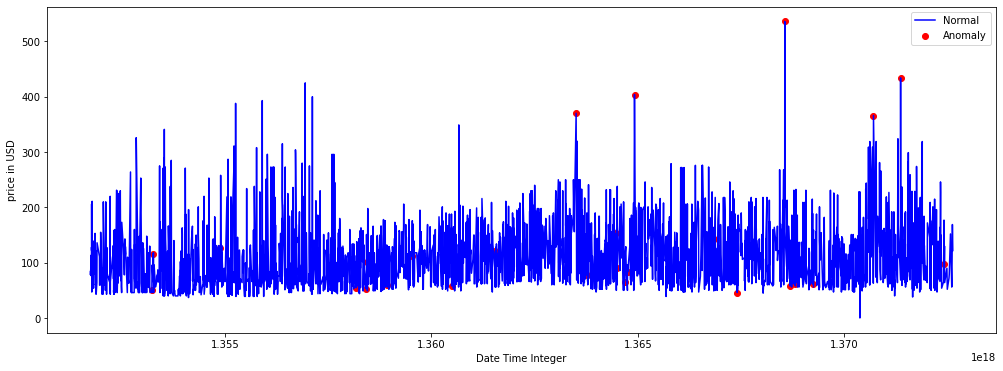

In [90]:
df = df.sort_values('date_time')
df['date_time_int'] = pd.to_datetime(df.date_time).astype(int)

fig, ax = plt.subplots(figsize=(17,6))
a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')

plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

### Isolation Forest for Anomaly Detection

Isolation forest is the first anomaly detection algorithm that identifies anomalies using isolation. This algorithm introduces a fundamentally different method that explicitly isolates anomalies using binary trees, demonstrating the new possibility of a fast anomaly detector that directly targets anomalies without having gone through the intensive process of normal instance profiling beforehand.

The IsolationForest "isolates" observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function. Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

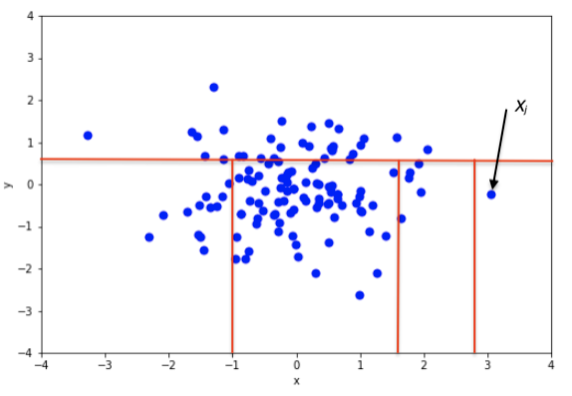

- When applying an IsolationForest model, we set contamination = outliers_fraction, that is telling the model that the proportion of outliers in the data set is 0.01.

- fit and predict(data) performs outlier detection on data, and returns 1 for normal, -1 for anomaly.

- Finally, we visualize anomalies with Time Series view.

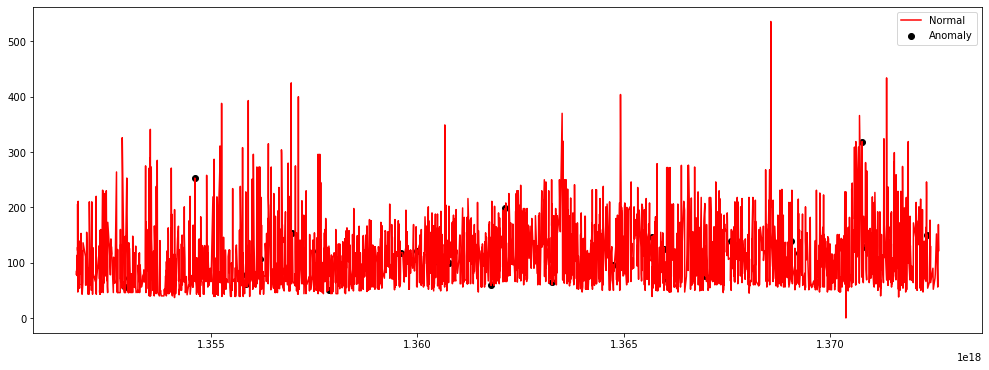

In [92]:
df_iso = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_iso)
df_iso = pd.DataFrame(np_scaled)

# train isolation forest
model = IsolationForest(contamination=outliers_fraction)
model.fit(df_iso) 
df['anomaly2'] = pd.Series(model.predict(df_iso))

# visualization
fig, ax = plt.subplots(figsize=(17,6))
a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='red', label = 'Normal')
ax.scatter(a['date_time_int'], a['price_usd'], color='black', label = 'Anomaly')
plt.legend()
plt.show();

### Support Vector Machine-Based Anomaly Detection

A support vector machine is another effective technique for detecting anomalies. A SVM is typically associated with supervised learning, but OneClassSVM can be used to identify anomalies as an unsupervised problems.

According to the paper: Support Vector Method for Novelty Detection. SVMs are max-margin methods, i.e. they do not model a probability distribution. The idea of SVM for anomaly detection is to find a function that is positive for regions with high density of points, and negative for small densities.

- Specifies the kernel type to be used in the algorithm: rbf. This will enable SVM to use a non-linear function to project the hyperspace to higher dimension.
- gamma is a parameter of the RBF kernel type and controls the influence of individual training samples - this effects the "smoothness" of the model. Through experimentation, I did not find any significant difference.

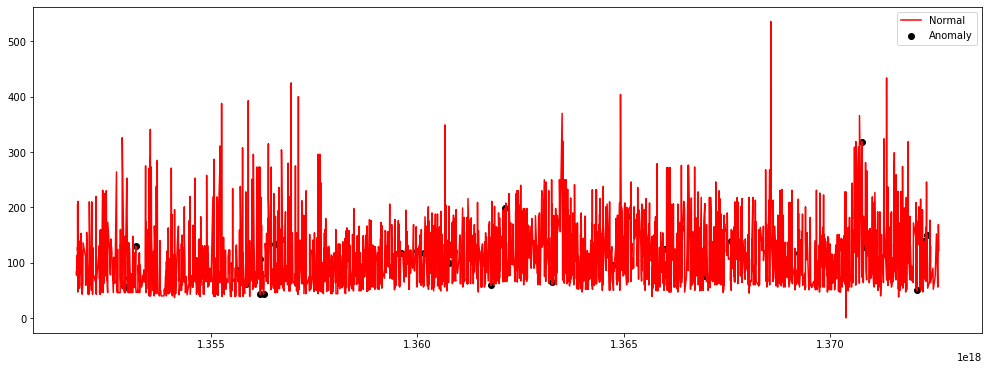

In [99]:
df_svm = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_svm)
df_svm = pd.DataFrame(np_scaled)

# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(df_svm)
df['anomaly3'] = pd.Series(model.predict(df_svm))

fig, ax = plt.subplots(figsize=(17,6))
a = df.loc[df['anomaly3'] == -1, ['date_time_int', 'price_usd']] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='red', label ='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='black', label = 'Anomaly')
plt.legend()
plt.show();

### Gaussian Distribution

Gaussian distribution is also called normal distribution. We will be using the Gaussian distribution to develop an anomaly detection algorithm, that is, we’ll assume that our data are normally distributed. This’s an assumption that cannot hold true for all data sets, yet when it does, it proves an effective method for spotting outliers.

Scikit-Learn’s covariance.EllipticEnvelope is a function that tries to figure out the key parameters of our data’s general distribution by assuming that our entire data is an expression of an underlying multivariate Gaussian distribution. The process like so:
- Create two different data sets based on categories defined earlier, ex. search_Sat_night, Search_Non_Sat_night.
- Apply EllipticEnvelope(gaussian distribution) at each categories.
- We set contamination parameter which is the proportion of the outliers present in our data set.
- We use decision_function to compute the decision function of the given observations. It is equal to the shifted Mahalanobis distances. The threshold for being an outlier is 0, which ensures a compatibility with other outlier detection algorithms.
- The predict(X_train) predict the labels (1 normal, -1 anomaly) of X_train according to the fitted model.

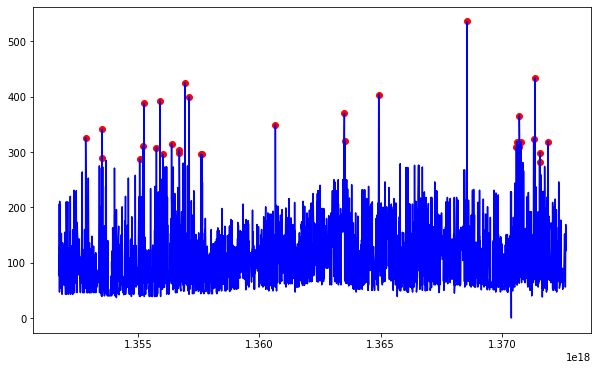

In [103]:
df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train_0 = df_class0.values.reshape(-1,1)
envelope.fit(X_train_0)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train_0)
df_class0['anomaly'] = envelope.predict(X_train_0)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train_1 = df_class1.values.reshape(-1,1)
envelope.fit(X_train_1)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train_1)
df_class1['anomaly'] = envelope.predict(X_train_1)

df_class = pd.concat([df_class0, df_class1])
df['anomaly4'] = df_class['anomaly']
fig, ax = plt.subplots(figsize=(10, 6))
a = df.loc[df['anomaly4'] == -1, ('date_time_int', 'price_usd')] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='blue')
ax.scatter(a['date_time_int'],a['price_usd'], color='red')
plt.show();